In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch #https://github.com/facebookresearch/esm

from Bio.PDB import PDBParser, PPBuilder
import pcmap
import math
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

import math
import torch.nn.functional as F

Picking random binder sequence from the meta-analysis dataset and predicting structure using AF:<br>
`../data/RAEL.pdb`

In [36]:
pdb_path = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/RAEL.pdb"
interaction_df = pd.read_csv("../data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})
seq = interaction_df["binder_seq"].sample(n=1, random_state=14).item()
print("Sequence:", seq, len(seq))

Sequence: RAELEAAAEAARAAAAARGHRMEYWFWKGTVAVLVSPRTPEVEALLAELRAAAAAAGYGLSVGAL 65


#### Contact map computed using `../data/RAEL.pdb` structure

Contact map size: (65, 65)


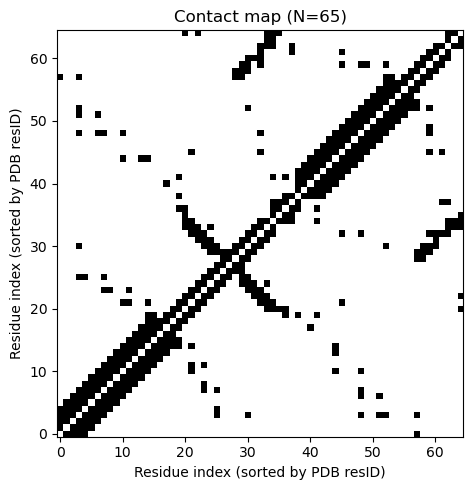

In [37]:
cmap = pcmap.contactMap(pdb_path)

# Collect all residue IDs that appear (roots + partners)
resids = []
for pos_dict in cmap["data"]:
    resids.append(int(pos_dict["root"]["resID"]))
    for inter in pos_dict["partners"]:
        resids.append(int(inter["resID"]))

uniq_resids = sorted(set(resids))
idx = {rid: i for i, rid in enumerate(uniq_resids)}
N = len(uniq_resids)

# Fill symmetric binary contact map
M = np.zeros((N, N), dtype=np.uint8)
for pos_dict in cmap["data"]:
    i = idx[int(pos_dict["root"]["resID"])]
    for inter in pos_dict["partners"]:
        j = idx[int(inter["resID"])]
        M[i, j] = 1
        M[j, i] = 1

print("Contact map size:", M.shape)

plt.figure(figsize=(5,5))
plt.imshow(M, origin="lower", interpolation="nearest", cmap="binary")
plt.title(f"Contact map (N={N})")
plt.xlabel("Residue index (sorted by PDB resID)")
plt.ylabel("Residue index (sorted by PDB resID)")
plt.tight_layout()
plt.show()

#### Dinstances between Cα–Cα computed using `../data/RAEL.pdb` and `PDBParser()`

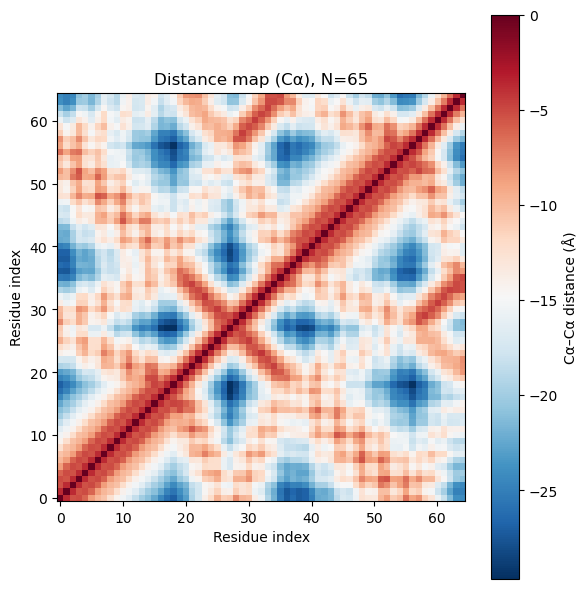

In [38]:
def ca_distance_matrix(pdb_path, chain_id=None):
    struct = PDBParser(QUIET=True).get_structure("s", pdb_path)
    cas, labels = [], []
    for model in struct:
        for chain in model:
            if chain_id and chain.id != chain_id:
                continue
            for res in chain:
                if res.id[0] != " " or "CA" not in res:
                    continue
                cas.append(res["CA"].coord)
                labels.append((chain.id, res.get_resname(), res.id[1], res.id[2].strip()))
            if chain_id:  # stop after chosen chain
                break
        break  # first model only
    X = np.asarray(cas)                     # [N,3]
    D = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(-1))  # [N,N]
    return D, labels

D, labels = ca_distance_matrix(pdb_path, chain_id=None)

# Save & plot
# np.savetxt("distance_matrix_ca.csv", D, fmt="%.3f", delimiter=",")
plt.figure(figsize=(6,6))
# plt.imshow(D, origin="lower", interpolation="nearest")
# plt.imshow(-D, origin="lower", interpolation="nearest", cmap="Blues")
plt.imshow(-D, origin="lower", interpolation="nearest", cmap="RdBu_r")
plt.colorbar(label="Cα–Cα distance (Å)")
plt.title(f"Distance map (Cα), N={D.shape[0]}")
plt.xlabel("Residue index")
plt.ylabel("Residue index")
plt.tight_layout()
plt.show()

### Loading ESMC model

In [39]:
model = ESMC.from_pretrained("esmc_600m", device=torch.device("cpu")).to("cuda")

/zhome/c9/0/203261/miniconda3/envs/esm_gpu/lib/python3.10/site-packages/esm/pretrained.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [40]:
print(model)

ESMC(
  (embed): Embedding(64, 1152)
  (transformer): TransformerStack(
    (blocks): ModuleList(
      (0-35): 36 x UnifiedTransformerBlock(
        (attn): MultiHeadAttention(
          (layernorm_qkv): Sequential(
            (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=1152, out_features=3456, bias=False)
          )
          (out_proj): Linear(in_features=1152, out_features=1152, bias=False)
          (q_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (k_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (rotary): RotaryEmbedding()
        )
        (ffn): Sequential(
          (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=1152, out_features=6144, bias=False)
          (2): SwiGLU()
          (3): Linear(in_features=3072, out_features=1152, bias=False)
        )
      )
    )
    (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)


In [41]:
all_tarnsformer_blocks = list(client.transformer.blocks)
len(all_tarnsformer_blocks)

36

In [48]:
# Bascially one layer of the transformer
all_tarnsformer_blocks[0]

UnifiedTransformerBlock(
  (attn): MultiHeadAttention(
    (layernorm_qkv): Sequential(
      (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=1152, out_features=3456, bias=False)
    )
    (out_proj): Linear(in_features=1152, out_features=1152, bias=False)
    (q_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (k_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (rotary): RotaryEmbedding()
  )
  (ffn): Sequential(
    (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=1152, out_features=6144, bias=False)
    (2): SwiGLU()
    (3): Linear(in_features=3072, out_features=1152, bias=False)
  )
)

This means your UnifiedTransformerBlock is a PyTorch nn.Module that has two submodules:
- (attn) MultiHeadAttention(...)→ a multi-head attention mechanism
- (ffn) Sequential(...) → a feed-forward network (the MLP part)

1. (attn) MultiHeadAttention(...) a.k.a. self-attention
- Sequential() is a container module in PyTorch (torch.nn.Sequential) that applies a sequence of layers one after the other, in order.
```
# First normalize the input; then linearly project it into one large tensor holding Q, K, and V
nn.Sequential(
    nn.LayerNorm((1152,), eps=1e-05, elementwise_affine=True),  
    # normalizes each input vector (of length 1152) so it has mean 0 and variance 1.
    # eps=1e-05 tiny constant for numerical stability
        # when normlaizing you devide by std, if the number is extra small, deviding can blow up. thus the constant is added
    
    nn.Linear(in_features=1152, out_features=3456, bias=False) # a fully connected (dense) layer.
    # in_features=1152 → expects input vectors of length 1152.
    # out_features=3456 → outputs vectors of length 3456.
    # bias=False → no bias term; purely a matrix multiply.
)
```
PyTorch internally creates one big weight matrix:
W ∈ R 1152×3456 = [Wq | Wk | Wv]

```
(out_proj): Linear(in_features=1152, out_features=1152, bias=False)
# After attention heads are combined, this linear layer mixes the outputs from all heads back into the same dimensionality as the input (1152).
```

```
(q_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
(k_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
# separate normalizations applied specifically to the queries (Q) and keys (K), respectively.
# reason: Q and K are used in a dot product (QK.T), and normalizing them helps keep their magnitudes stable, preventing exploding/vanishing attention scores.

(rotary): RotaryEmbedding()
# Rotary positional embedding (RoPE) is an alternative to positional encoding. Instead of adding position vectors, it rotates the Q and K vectors in multi-dimensional space by angles that depend on their positions in the sequence.
```
2. ffn: Sequential(...)
```
(ffn): Sequential(
  (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True) # normalize input activations before applying the feed-forward network.
  (1): Linear(in_features=1152, out_features=6144, bias=False) # expand feature dimesnions. as FFNs in Transformers use expansion to give more representational power.
  (2): SwiGLU() # Split → (3072, 3072), improves nonlinearity
  (3): Linear(in_features=3072, out_features=1152, bias=False)
)
```

- LayerNorm() - stabilizes gradients, ensures consistent **scale**
- Linear() - **projects** between feature spaces
- Sequential() - runs sub-layers **in order**
- MultiHeadAttention() - let's tokens **interact**
- RotaryEmbedding() - ***encodes order** via rotation
- SwiGLU - improves **nonlinearity**
- out_proj - recombine attention heads
- q_ln / k_ln - helps attention stability

In [64]:
blocks = list(model.transformer.blocks)
attn = blocks[0].attn

# Correct:
print(attn.head_dim)        # e.g., 16

# Wrong (what caused your error):
# attn.num_heads()

AttributeError: 'MultiHeadAttention' object has no attribute 'head_dim'

In [32]:
@torch.no_grad()
def capture_attention_ESMC(model):
    """
    computes attention manually inside your wrapper, and
    stashes the attention weights (softmax(QK.T/sqrt(d))) into attn._attn.
    """
    blocks = list(model.transformer.blocks) # 36 layers of the model
    # print(len(blocks)) # 36

    # attn = all_tarnsformer_blocks[X].attn
    def patch(attn):
        orig = attn.forward  # keep original forward (not used later but kept for reference)
        # print(orig)

        # defining replaccement forward network
        def fwd(x, attn_mask=None):
            B, L, D = x.shape # batch. seq_length, 1152
            H = attn.num_heads
            d = D // H # head dimension

            # QKV: [B,L,3D] -> split into [B,L,D] each
            qkv = attn.layernorm_qkv(x) # the attention module has a combined, LN-aware QKV projection (layernorm_qkv).
            q, k, v = torch.chunk(qkv, 3, dim=-1) # splits the last dimension into Q, K, V

            # optional per-tensor norms
            if hasattr(attn, "q_ln"): q = attn.q_ln(q)
            if hasattr(attn, "k_ln"): k = attn.k_ln(k)

            # to heads: [B,L,D] -> [B,H,L,d]
            def heads(t): return t.view(B, L, H, d).transpose(1, 2).contiguous()
            q, k, v = heads(q), heads(k), heads(v)

            # rotary (if present)
            # if getattr(attn, "rotary", None) is not None:
            #     q, k = attn.rotary(q, k)

            # scaled dot-product attention
            scores = (q @ k.transpose(-1, -2)) / math.sqrt(d)   # [B,H,L,L]
            if attn_mask is not None:
                scores = scores + attn_mask
            probs = F.softmax(scores, dim=-1)                   # [B,H,L,L]

            # aggregate and merge heads
            ctx = probs @ v                                     # [B,H,L,d]
            ctx = ctx.transpose(1, 2).reshape(B, L, D)          # [B,L,D]

            out = attn.out_proj(ctx)                            # [B,L,D]
            attn._attn = probs.detach()                         # stash
            return out

        attn.forward = fwd

    for block in blocks:
        patch(block.attn)

    def collect(): # athers all saved attention maps from every layer into one big tensor.
        return torch.stack([blk.attn._attn.cpu() for blk in blocks], dim=0)

    return collect


collect = capture_attention_ESMC(model)
with torch.no_grad():
    _ = model(tokens)        # run as usual
A = collect()                # [layers, B, heads, L, L]

### Contact map form the ESM model:

`contacts = model(batch_tokens, repr_layers=[L], return_contacts=True)["contacts"][0]`

In [ ]:
data = [("protein1", seq)]  # <- single sequence

# Make batch
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)  # tensor([L_plus_special])

with torch.no_grad():
    # use the model's last layer automatically
    L = model.num_layers
    out = model(batch_tokens, repr_layers=[L], return_contacts=True)

token_reps = out["representations"][L]      # shape: [1, T, H]
tokens_len = int(batch_lens[0])             # includes BOS/EOS

# Per-sequence embedding (average of residue tokens; skip BOS/EOS)
seq_emb = token_reps[0, 1:tokens_len-1].mean(0)  # shape: [H]

# Contact map (trim to actual tokens_len if needed)
contacts = out["contacts"][0]               # shape: [T, T]
contacts = contacts[:tokens_len, :tokens_len]

plt.figure(figsize=(5,5))
plt.imshow(contacts, origin="lower", interpolation="nearest", cmap="binary")
plt.title("ESM-2 attention contacts")
plt.xlabel("Token index")
plt.ylabel("Token index")
plt.tight_layout()
plt.show()

### Comapring all 3: cmap vs -D vs contacts

In [ ]:
# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# M
im0 = axes[0].imshow(M, origin="lower", interpolation="nearest", cmap="binary")
axes[0].set_title(f"M (L={model.num_layers})")
axes[0].set_xlabel("Residue index"); axes[0].set_ylabel("Residue index")
cb0 = fig.colorbar(im0, ax=axes[0])
cb0.set_label("M value")

# D (plotted as -D per your example)
im1 = axes[1].imshow(-D, origin="lower", interpolation="nearest", cmap="RdBu_r")
axes[1].set_title(f"Distance map (Cα), N={D.shape[0]}")
axes[1].set_xlabel("Residue index"); axes[1].set_ylabel("Residue index")
cb1 = fig.colorbar(im1, ax=axes[1])
cb1.set_label("− distance (Å)")

# Contacts
im2 = axes[2].imshow(contacts, origin="lower", interpolation="nearest", cmap="binary")
axes[2].set_title("Contacts from the ESM2 model last attention layer")
axes[2].set_xlabel("Residue index"); axes[2].set_ylabel("Residue index")
cb2 = fig.colorbar(im2, ax=axes[2])
cb2.set_label("Contact prob / score")

plt.show()

In [ ]:
batch_tokens # encoding of amino acids used

- `batch_tokens` is a `torch.LongTensor` shaped [1, T] (batch of 1).
- Index 0 (0) is the `BOS` token (begin-of-sequence).
- Last index (2) is the `EOS` token (end-of-sequence).
- Everything in between are amino-acid token IDs.
- In `ESM-2`, `alphabet.cls_idx == 0`, `alphabet.padding_idx == 1`, `alphabet.eos_idx == 2`.

In [ ]:
# decode ID --> letter
T = int((batch_tokens != alphabet.padding_idx).sum())
ids = batch_tokens[0, 1:T-1].tolist()             # drop BOS/EOS
letters = [alphabet.get_tok(i) for i in ids]      # map IDs to tokens
seq_back = "".join(letters)
print("T:", T) # kength of the protein sequence + BOS/EOS, i.e., batch tokens 0, 2
print("Decoded residues:", seq_back)

In [ ]:
with torch.no_grad():
    repr_layers = list(range(model.num_layers + 1))
    out = model(batch_tokens,
                repr_layers=repr_layers,
                return_contacts=True) 

out.keys()
# out["representations"] # embeddings
# out["attentions"] # all the attentions: 33 layers, 20 heads
# out["contacts"] # contact map

In [ ]:
out["attentions"].shape

# torch.Size([ 1,   33,   20,   73,   73 ])
#              │     │     │      │     └── src_len  (keys)
#              │     │     │      └──────── tgt_len  (queries)
#              │     │     └─────────────── n_heads  (per layer)
#              │     └───────────────────── n_layers (ESM-2 t33 → 33)
#              └─────────────────────────── batch_size (here 1)

## Plotting last layer (33rd) all the heads separately to see which capture structural information

In [ ]:
attentions = out["attentions"]
A = attentions[0, -1, :, :, :]   # [H, T', T']
H = A.shape[0]

# Drop BOS/EOS so it’s residue-only
T_valid = int((batch_tokens != alphabet.padding_idx).sum())
if T_valid >= 2:
    A = A[:, 1:-1, 1:-1]                       # [H, Lres, Lres]

# Plot all heads
cols = 5
rows = math.ceil(H / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3.0*cols, 3.0*rows), constrained_layout=True)
axes = axes.ravel()

# Shared color scale (helps compare heads)
vmin = float(A.min())
vmax = float(A.max())

im0 = 0
for h in range(rows*cols):
    ax = axes[h]
    if h < H:
        M = A[h].detach().cpu().numpy()
        im0 = ax.imshow(M, origin="lower", interpolation="nearest", cmap="binary",
                        vmin=vmin, vmax=vmax)
        ax.set_title(f"Layer L, Head {h+1}", fontsize=10)
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
        ax.tick_params(labelsize=8)
    else:
        ax.axis("off")

if im0 is not None:
    fig.colorbar(im0, ax=axes.tolist(), fraction=0.02, pad=0.02)

fig.suptitle("ESM-2 — Last Layer Attention (all heads)", fontsize=14)
plt.show()

### P@L

In [ ]:
struct = PDBParser(QUIET=True).get_structure("s", pdb_path)
# collect Cα coords
X = np.asarray(coords) # [length, 3 coordinates]
N = len(X) # length 
D = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(-1))  # [N,N] # pairwise distances
T = (D <= 8)
print(D)
# # # remove self and short-range
# i, j = np.triu_indices(N, k=1)
# short = (np.abs(i-j) < 6)
# T[i[short], j[short]] = False
# T[j[short], i[short]] = False

# plt.figure(figsize=(5,5))
# plt.imshow(T, origin="lower", interpolation="nearest", cmap="binary")
# plt.title(f"Contact map (N={T.shape[0]})")
# plt.xlabel("Residue index (sorted by PDB resID)")
# plt.ylabel("Residue index (sorted by PDB resID)")
# plt.tight_layout()
# plt.show()

In [ ]:
D.shape

In [ ]:
# --- 1) build ground-truth contacts (Cα ≤ 8 Å by default) ---
def true_contacts_ca(pdb_path, chain_id=None, cutoff=8.0, min_seq_sep=6):
    struct = PDBParser(QUIET=True).get_structure("s", pdb_path)
    # collect Cα coords
    coords = [res["CA"].coord for res in struct[0]["A"] if res.id[0] == " " and "CA" in res]
    X = np.asarray(coords) # [len, 3 coordinates of Cα]
    N = len(X) # length of the sequence
    D = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(-1))  # [N,N] # Cα–Cα pairwise distance matrix
    T = (D <= cutoff) # True where the distance is smaller than cutoff
    # remove self and short-range
    i,j = np.triu_indices(N, k=1)
    short = (np.abs(i-j) < min_seq_sep)
    T[i[short], j[short]] = False
    T[j[short], i[short]] = False

    plt.figure(figsize=(5,5))
    plt.imshow(-D, origin="lower", interpolation="nearest", cmap="binary")
    plt.title(f"Contact map, not filtered (N={T.shape[0]})")
    plt.xlabel("Residue index (sorted by PDB resID)")
    plt.ylabel("Residue index (sorted by PDB resID)")
    plt.tight_layout()
    plt.show()
    
    return T

# --- 2) Precision@K on matrices ---
def precision_at_k(scores, truth_bool, K):
    """scores, truth_bool: NxN (upper triangle used, excluding diagonal)"""
    N = scores.shape[0]
    i, j = np.triu_indices(N, k=1)
    # (optional) exclude short-range already masked in truth_bool
    mask = np.ones_like(i, dtype=bool)
    # keep only pairs that exist in truth (or all pairs if you prefer):
    # mask = np.ones_like(i, dtype=bool)
    s = scores[i, j]
    t = truth_bool[i, j].astype(bool)

    # rank by predicted score (desc) and take top-K
    order = np.argsort(-s)
    top = order[:K]
    return float(t[top].sum()) / K

# --- 3) Convenience wrappers ---
def precision_at_L(scores, truth_bool): 
    N = scores.shape[0]
    return precision_at_k(scores, truth_bool, K=N)

def precision_at_L2(scores, truth_bool): 
    N = scores.shape[0]
    return precision_at_k(scores, truth_bool, K=max(1, N//2))

def precision_at_L5(scores, truth_bool): 
    N = scores.shape[0]
    return precision_at_k(scores, truth_bool, K=max(1, N//5))

# After you run ESM-2 and get "results" and tokens_len
L = int(tokens_len) - 2                 # exclude BOS/EOS
S = out["contacts"][0][:L, :L].cpu().numpy()  # predicted scores (NxN)

T = true_contacts_ca("../data/RAEL.pdb", chain_id="A", cutoff=8.0, min_seq_sep=6)

print("P@L  =", precision_at_L(S, T))
print("P@L/2=", precision_at_L2(S, T))
print("P@L/5=", precision_at_L5(S, T))
